In [1010]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error  # mean_squared_log_error
import requests
from sklearn.model_selection import GridSearchCV

In [938]:
df = pd.read_parquet('/Users/laceymorgan/Desktop/energy_consumption_xgb_model/est_hourly.paruqet')
df.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


In [939]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


In [940]:
df.isnull().sum()

AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

In [941]:
# bring Datetime index to column
df.reset_index(inplace=True)

In [942]:
df.dtypes

Datetime    datetime64[ns]
AEP                float64
COMED              float64
DAYTON             float64
DEOK               float64
DOM                float64
DUQ                float64
EKPC               float64
FE                 float64
NI                 float64
PJME               float64
PJMW               float64
PJM_Load           float64
dtype: object

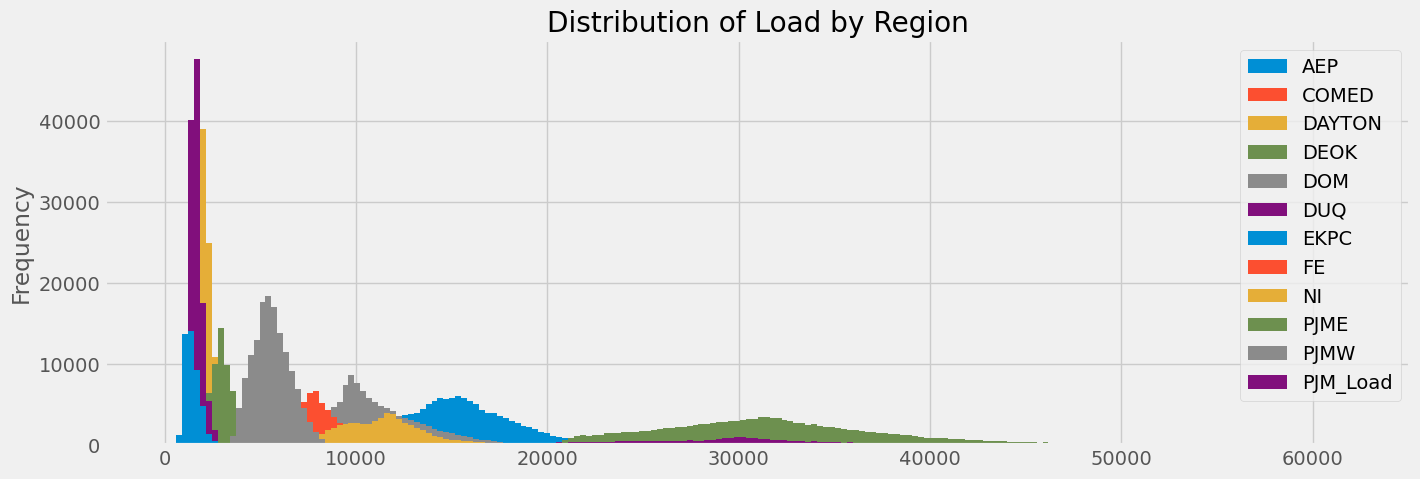

In [943]:
# Looking at distribution of load by region
df.plot.hist(figsize=(15, 5), bins=200, title='Distribution of Load by Region')
plt.show()

### Plotting timeseries

In [944]:
# set datetime as index
df.set_index('Datetime', inplace=True)

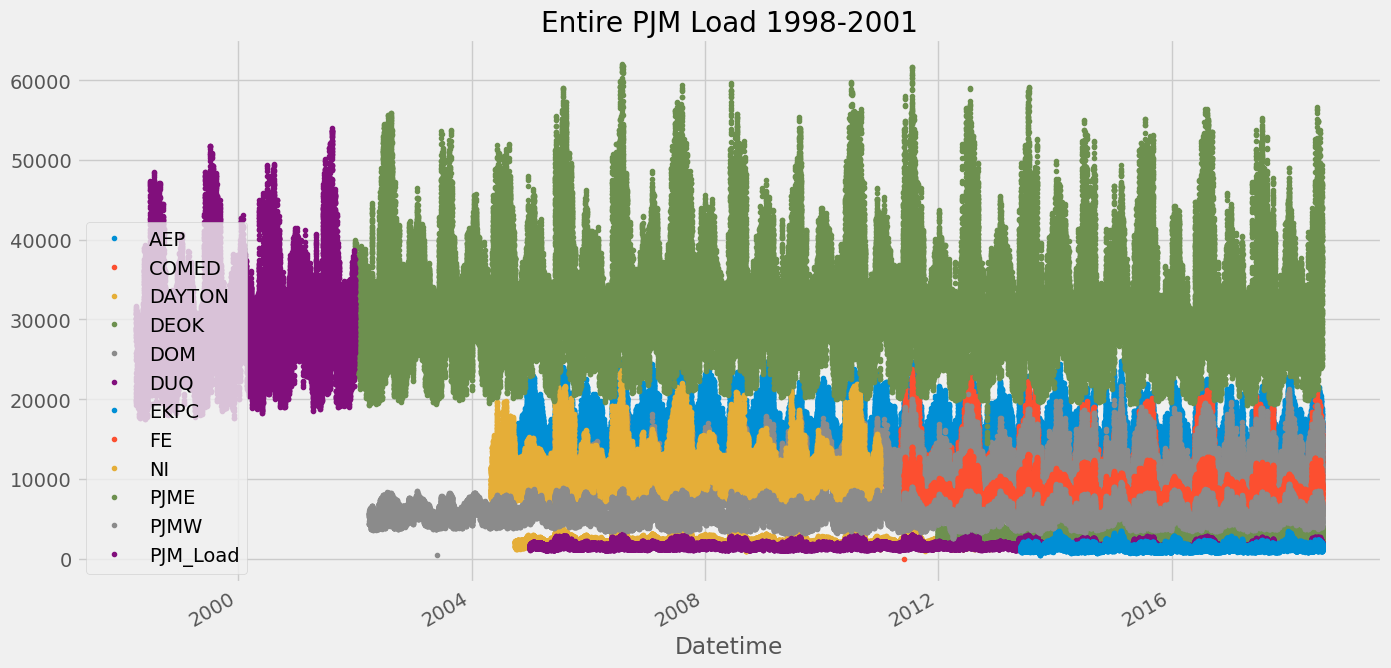

In [945]:
plot = df.plot(style='.', figsize=(15, 8), title='Entire PJM Load 1998-2001')


#### Summer Demand vs Winter Demand

We see dips mid-day in the winter months. Conversely in summer months the daily load is more bell shaped. This is due to high mid-day energy consumtion by air conditioning. In winter months people tend to use less energy mid-day.


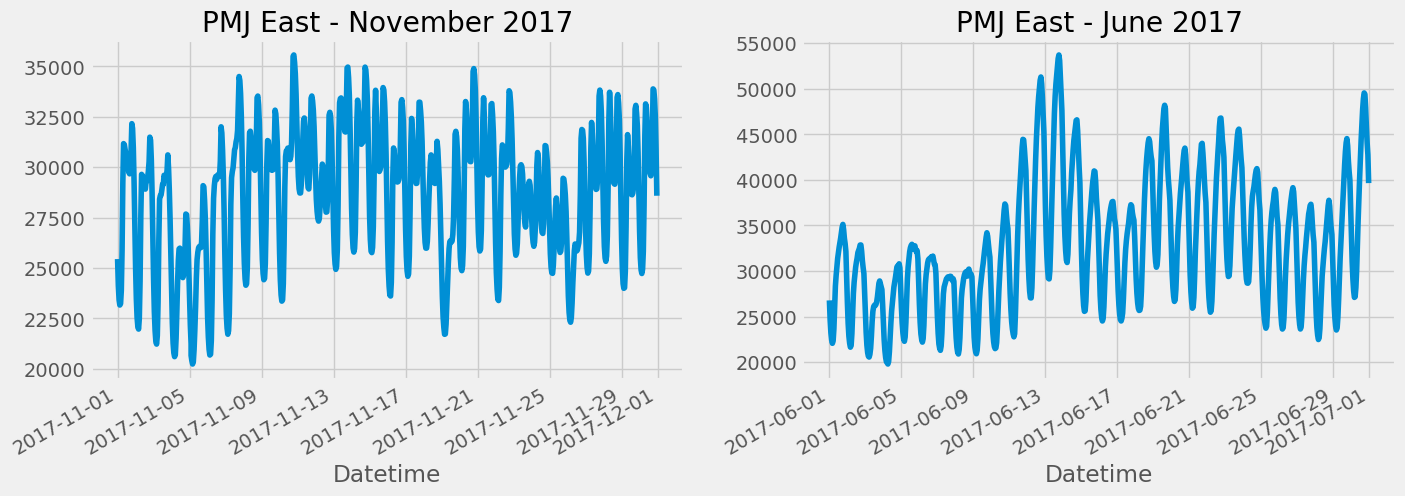

In [946]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the first line on the first axis
df['PJME'].loc[(df['PJME'].index >= '2017-11-01') & (df['PJME'].index < '2017-12-01')].plot(ax=ax1, title='PMJ East - November 2017')

# plot the second line on the second axis
df['PJME'].loc[(df['PJME'].index >= '2017-06-01') & (df['PJME'].index < '2017-07-01')].plot(ax=ax2, title='PMJ East - June 2017')

# show the plot
plt.show()

#### Create timeseries features

In [947]:
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.strftime('%A')
# df['woy'] = df.index.week
df['dom'] = df.index.day # Day of Month
df['date'] = df.index.date 

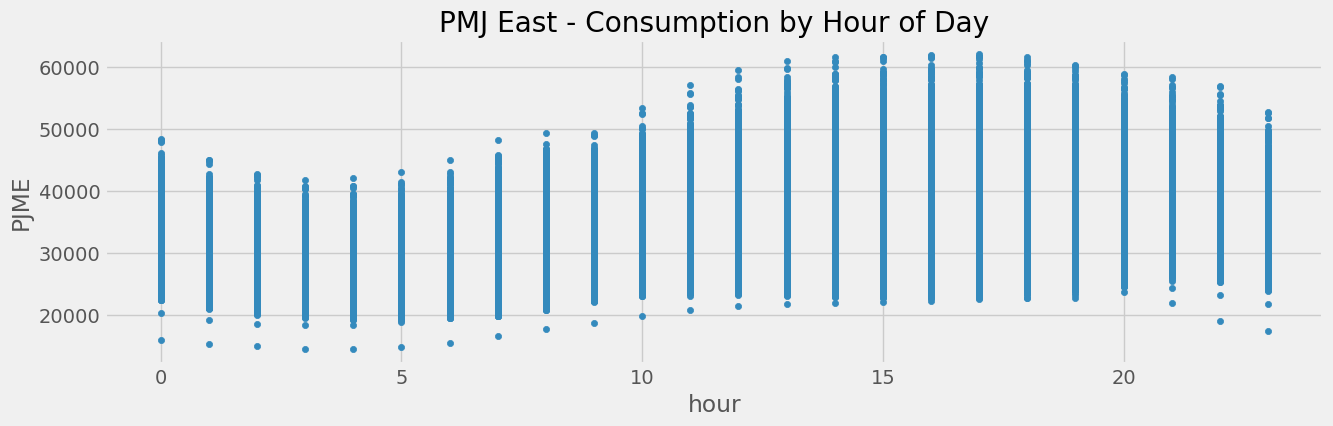

In [948]:
_ = df[['PJME','hour']].plot(x='hour',
                                     y='PJME',
                                     kind='scatter',
                                     figsize=(14,4),
                                     title='PMJ East - Consumption by Hour of Day')

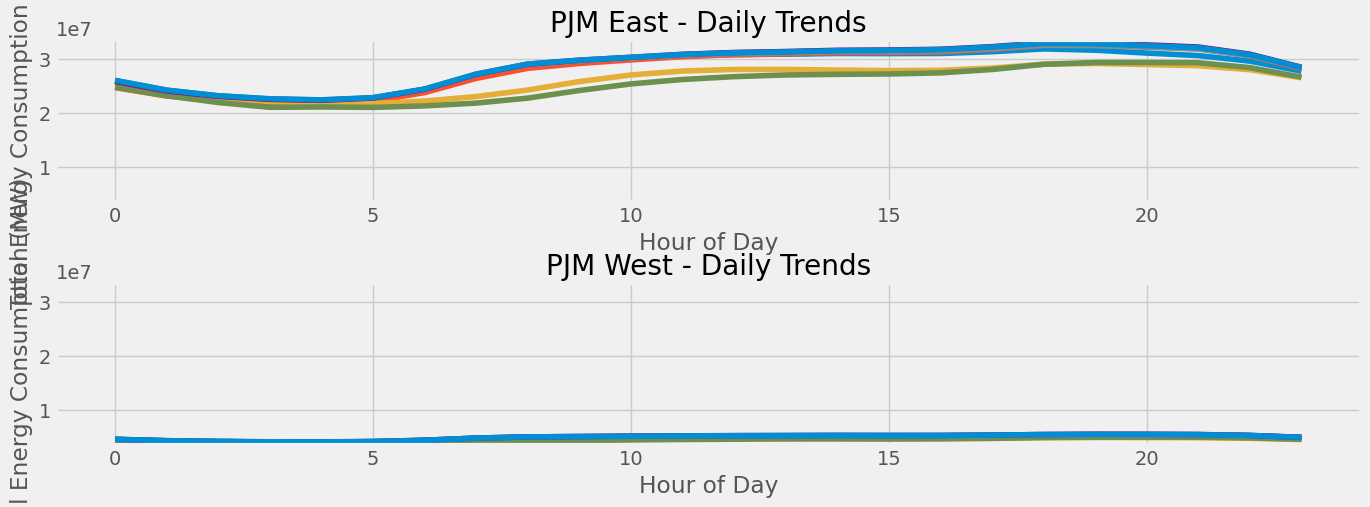

In [949]:
# show PJM East and PMJ West daily trends on the same fig

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))

df.pivot_table(index=df['hour'], 
               columns='weekday', 
               values='PJME',
               aggfunc='sum').plot(ax=ax1,
                                   title='PJM East - Daily Trends',
                                   legend=False)

df.pivot_table(index=df['hour'],
               columns='weekday',
               values='PJMW',
               aggfunc='sum').plot(ax=ax2,
                                   title='PJM West - Daily Trends',
                                   legend=False)

# set y limits to be the same for both plots
ymin = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

ax1.set_ylabel('Total Energy Consumption (MW)')
ax2.set_ylabel('Total Energy Consumption (MW)')
ax1.set_xlabel('Hour of Day')
ax2.set_xlabel('Hour of Day')

fig.subplots_adjust(hspace=0.5)

plt.show()


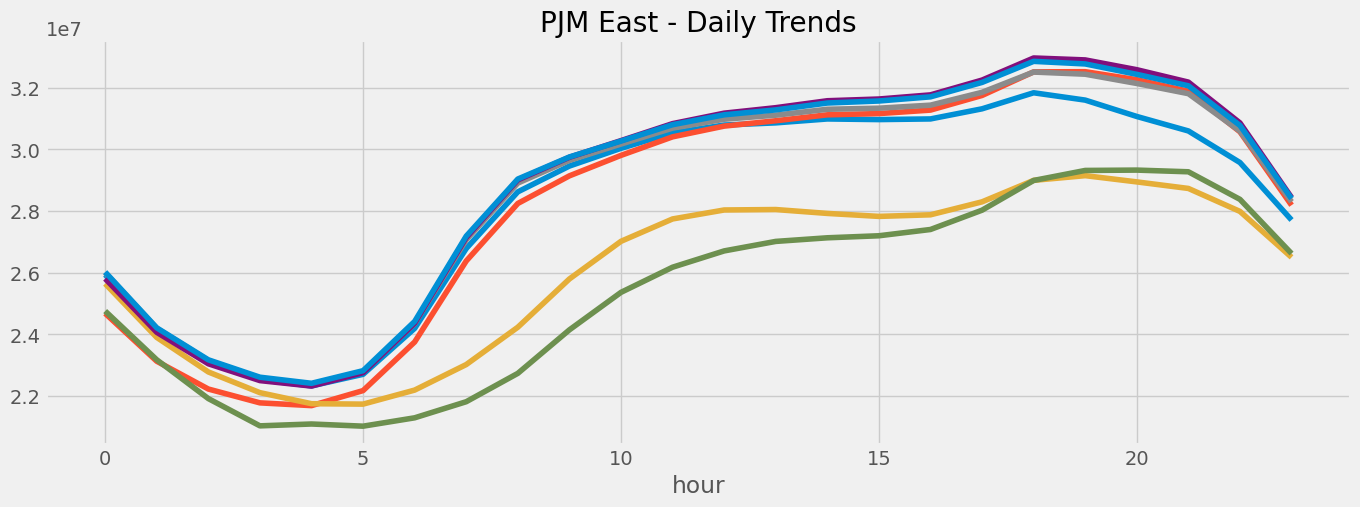

In [950]:
# Looking at just PJM East daily trends
df.pivot_table(index=df['hour'], 
               columns='weekday', 
               values='PJME',
               aggfunc='sum').plot(figsize=(15, 5),
                            title='PJM East - Daily Trends',
                            legend=False)

plt.show()

### Looking at just PJM East for building a regression model

In [951]:
pjm3_df = df[['PJME']].set_index(pd.to_datetime(df.index))
pjm3_df.head()

,PJME
Datetime,
1998-12-31 01:00:00,NaN
1998-12-31 02:00:00,NaN
1998-12-31 03:00:00,NaN
1998-12-31 04:00:00,NaN
1998-12-31 05:00:00,NaN


In [952]:
pjm3_df.isnull().sum()

PJME    32896
dtype: int64

In [953]:
# drop null values
pjm3_df.dropna(inplace=True)

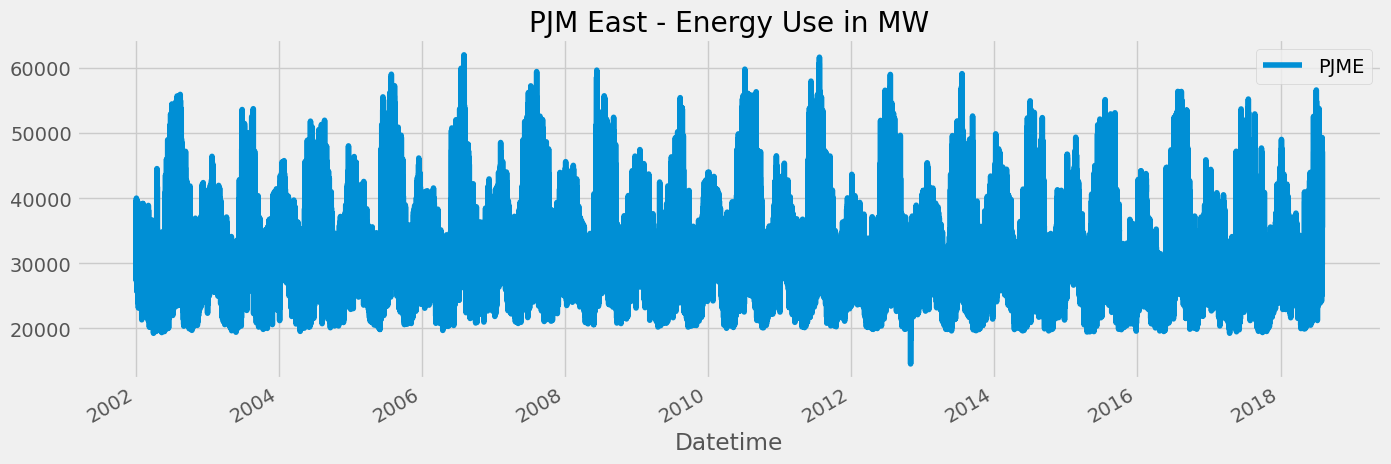

In [954]:
# Visualize the time series data
pjm3_df.plot(figsize=(15, 5), title='PJM East - Energy Use in MW')

plt.show()

In [955]:
train= pjm3_df.loc[pjm3_df.index < '2015-01-01']
test= pjm3_df.loc[pjm3_df.index >= '2015-01-01']

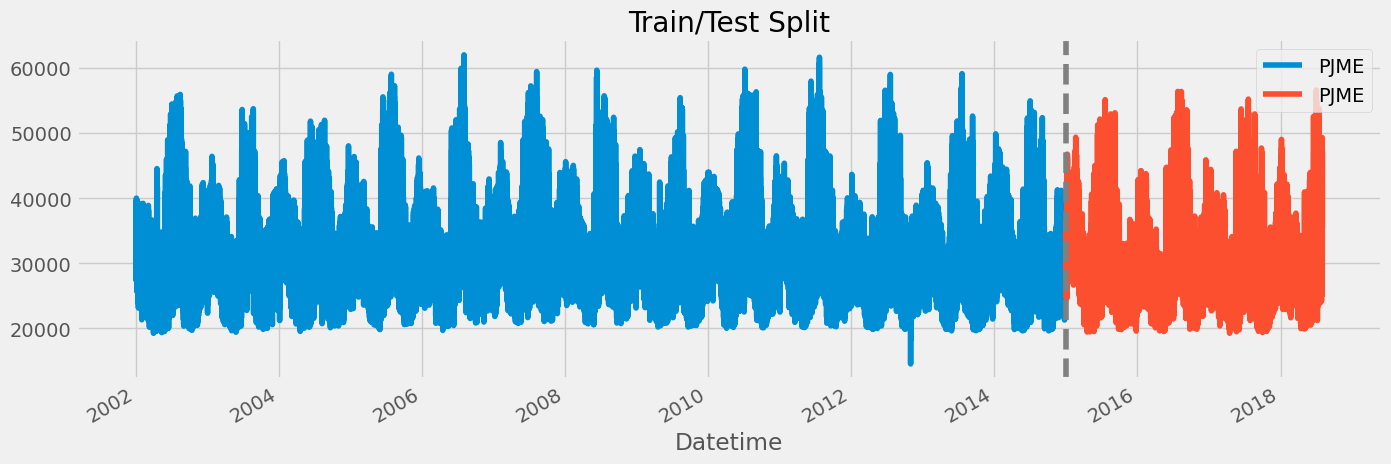

In [956]:
# Visualize the split

fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
ax.axvline(x='2015-01-01', linestyle='--', color='gray')
ax.set_title('Train/Test Split')

plt.show()

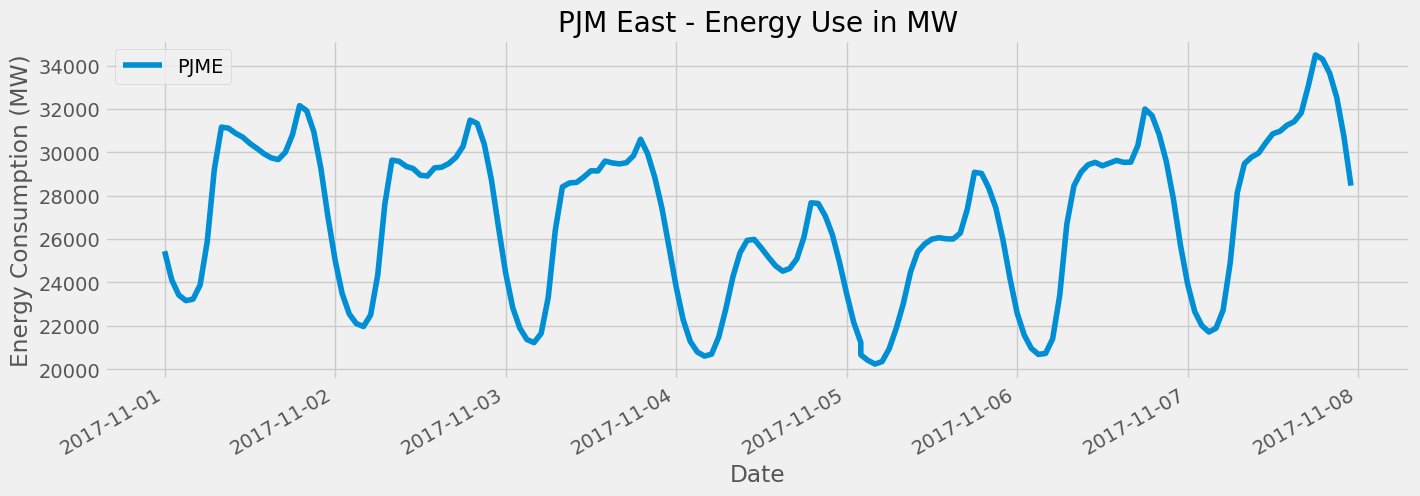

In [957]:
# looking at a week of data
test.loc[(test.index >= '2017-11-01') & (test.index < '2017-11-08')].\
    plot(figsize=(15, 5), title='PJM East - Energy Use in MW')

plt.ylabel('Energy Consumption (MW)')
plt.xlabel('Date')

plt.show()

### Feature creation

In [958]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df


In [959]:
test = test.copy()
create_features(test)

,PJME,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


In [960]:
train = train.copy()
create_features(train)

,PJME,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2014-01-01 20:00:00,36193.0,20,2,1,1,2014,1
2014-01-01 21:00:00,35601.0,21,2,1,1,2014,1
2014-01-01 22:00:00,34242.0,22,2,1,1,2014,1


Visualize Feature/Target Relationship

Text(0.5, 0, 'Hour of Day')

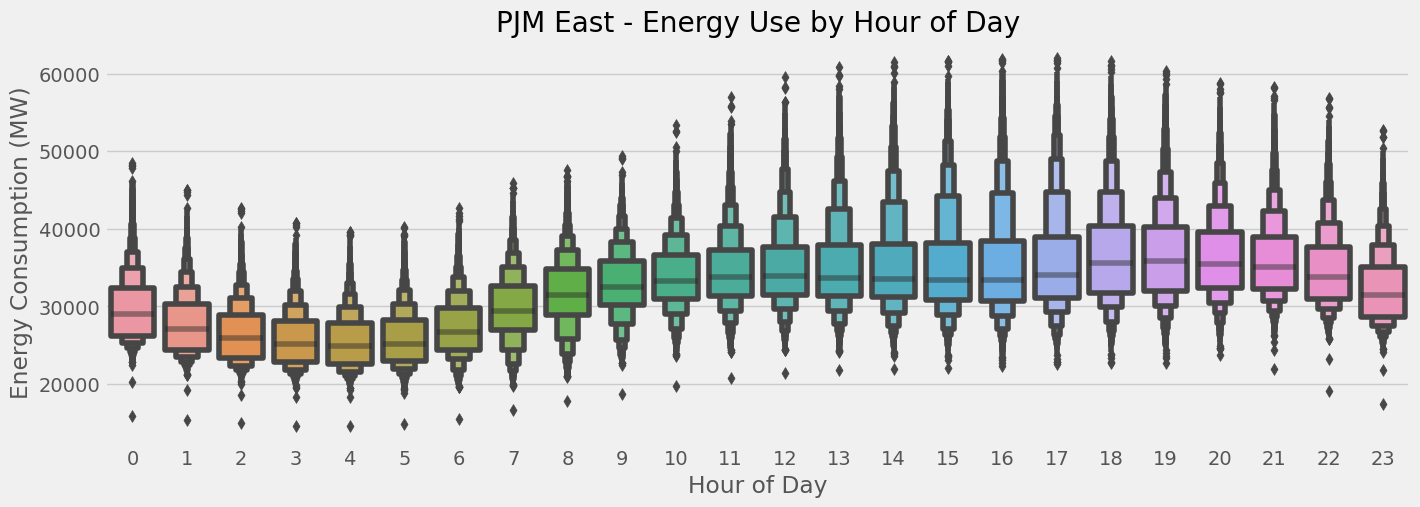

In [961]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxenplot(data=train, x='hour', y='PJME', ax=ax)
ax.set_title('PJM East - Energy Use by Hour of Day')
ax.set_ylabel('Energy Consumption (MW)')
ax.set_xlabel('Hour of Day')

Text(0.5, 0, 'Month')

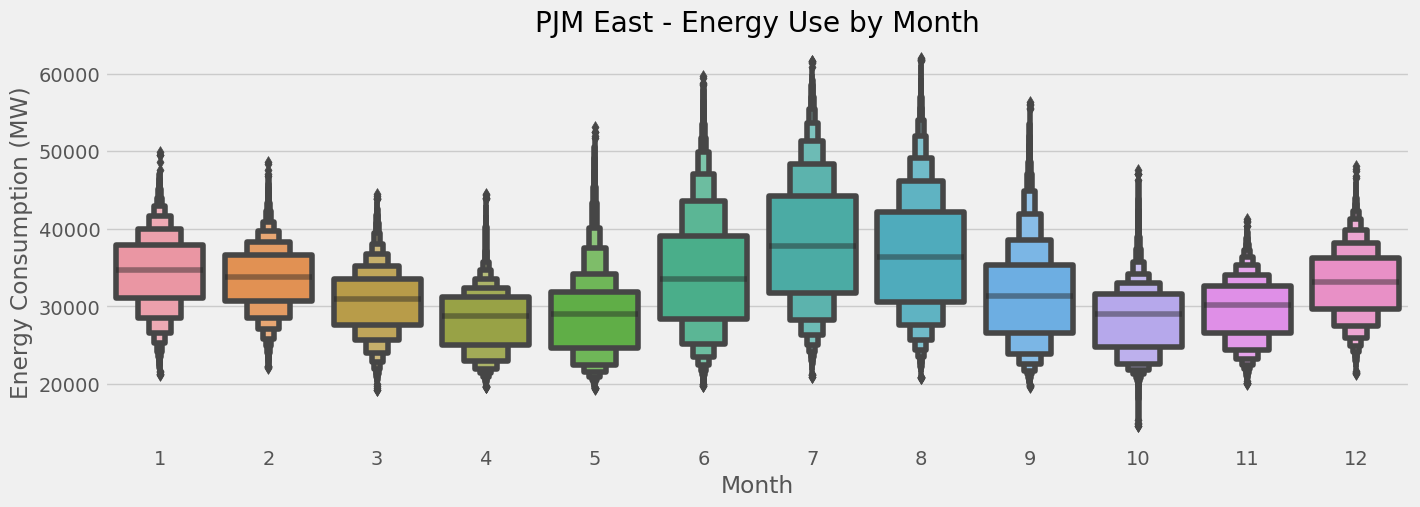

In [962]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxenplot(data=train, x='month', y='PJME', ax=ax)
ax.set_title('PJM East - Energy Use by Month')
ax.set_ylabel('Energy Consumption (MW)')
ax.set_xlabel('Month')

### Create Model

In [963]:
train.columns

Index(['PJME', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [964]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['PJME']

In [965]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [966]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.1) 
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:29676.17870	validation_1-rmse:28732.06789
[1]	validation_0-rmse:26754.48086	validation_1-rmse:25796.71425
[2]	validation_0-rmse:24128.08882	validation_1-rmse:23182.77540
[3]	validation_0-rmse:21768.12573	validation_1-rmse:20830.31759
[4]	validation_0-rmse:19649.53432	validation_1-rmse:18735.25923
[5]	validation_0-rmse:17746.02850	validation_1-rmse:16859.42394
[6]	validation_0-rmse:16040.20153	validation_1-rmse:15180.60453
[7]	validation_0-rmse:14509.48512	validation_1-rmse:13669.25983
[8]	validation_0-rmse:13138.42017	validation_1-rmse:12321.56740
[9]	validation_0-rmse:11910.74948	validation_1-rmse:11128.41809
[10]	validation_0-rmse:10814.35756	validation_1-rmse:10064.92295
[11]	validation_0-rmse:9833.35755	validation_1-rmse:9133.35091
[12]	validation_0-rmse:8960.87276	validation_1-rmse:8292.77509
[13]	validation_0-rmse:8180.91162	validation_1-rmse:7577.31791
[14]	validation_0-rmse:7491.13627	validation_1-rmse:6926.56211
[15]	validation_0-rmse:6878.83967	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature Importance

In [967]:
fi = pd.DataFrame(data=reg.feature_importances_,
                index =reg.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=True)

In [968]:
fi.head()

,importance
year,0.029738
quarter,0.044037
dayofweek,0.128139
dayofyear,0.132233
month,0.204657


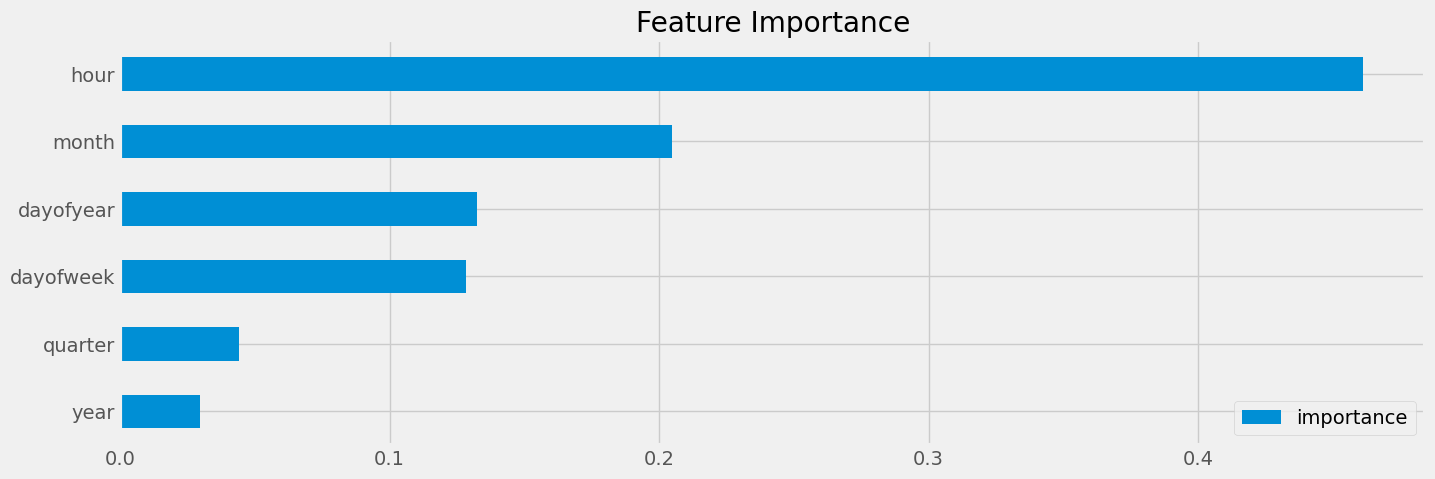

In [969]:
fi.plot(kind='barh', figsize=(15, 5), title='Feature Importance')
plt.show()

### Forecast on the Test set

In [970]:
test['prediction'] = reg.predict(X_test)

In [971]:
test.head()

,PJME,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,31733.287109
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,27754.167969
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,26861.980469
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26592.394531
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26592.394531


In [972]:
df_w_predictions = pjm3_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [973]:
create_features(df_w_predictions)

,PJME,prediction,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,NaN,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,NaN,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,NaN,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,NaN,5,1,1,1,2002,1
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,41472.394531,20,3,3,8,2018,214
2018-08-02 21:00:00,43256.0,40846.320312,21,3,3,8,2018,214
2018-08-02 22:00:00,41552.0,38270.093750,22,3,3,8,2018,214


Text(0.5, 1.0, 'Raw Data vs. Predictions')

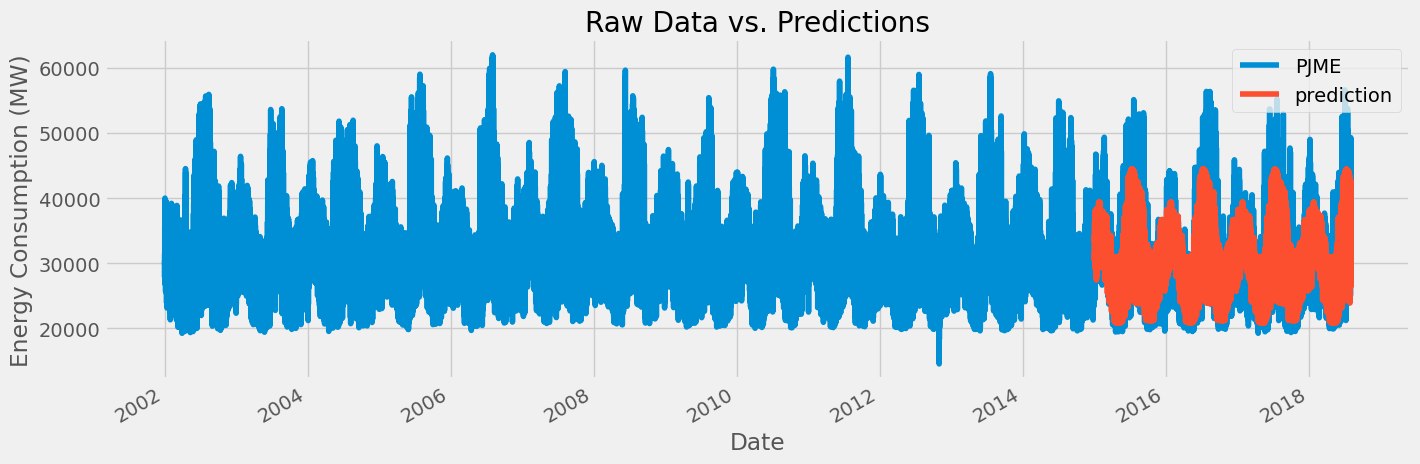

In [974]:
ax = df_w_predictions[['PJME', 'prediction']].plot(figsize=(15, 5), title='PJM East - Energy Use in MW')
ax.set_ylabel('Energy Consumption (MW)')
ax.set_xlabel('Date')
ax.set_title('Raw Data vs. Predictions')

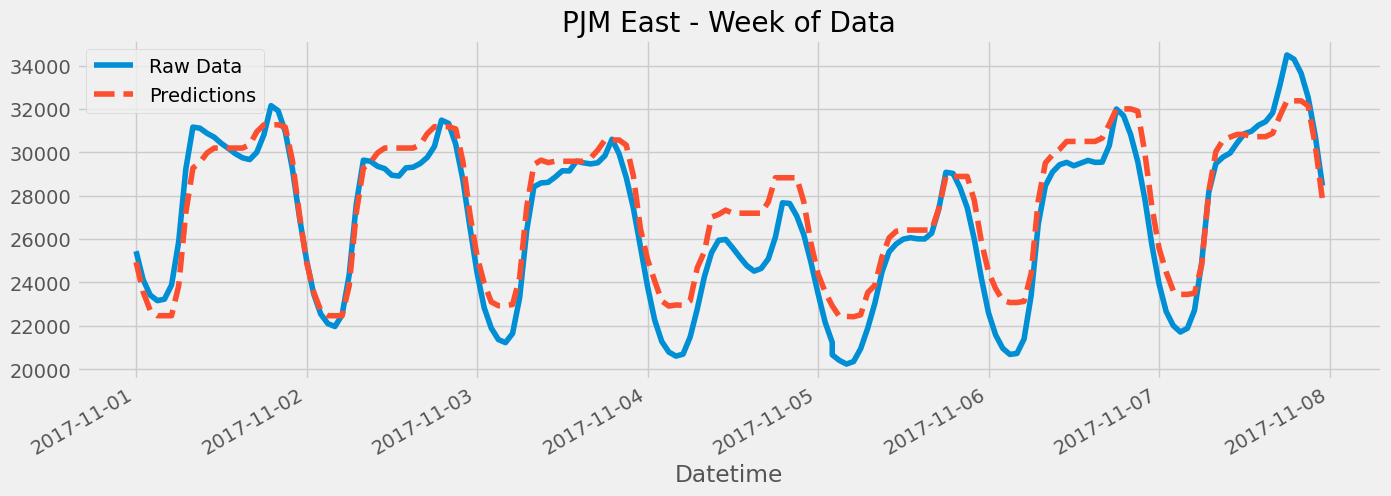

In [975]:
ax = df_w_predictions.loc[(df_w_predictions.index >= '2017-11-01') & (df_w_predictions.index < '2017-11-08')][['PJME', 'prediction']].\
    plot(figsize=(15, 5), title='PJM East - Week of Data', style=['-', '--'])
plt.legend(['Raw Data', 'Predictions'])
plt.show()

In [976]:
score = np.sqrt(mean_squared_error(test['PJME'], test['prediction']))
print(f'RMSE of test set: {round(score,4)}')

RMSE of test set: 3732.8471


### Calculate error
Look at the worst and best predicted days

In [977]:
test['error'] = np.abs(test['PJME'] - test['prediction'])

In [978]:
test['date'] = test.index.date

In [979]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    15061.483480
2016-08-14    14852.224609
2016-09-10    12478.755778
2016-09-09    11713.514648
2016-08-12    11243.524007
2018-01-06    11149.075439
2015-02-20    11086.833659
2018-01-07    10527.138753
2017-05-19    10351.015951
2015-02-16    10331.820150
Name: error, dtype: float64

In [980]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)

date
2016-05-01    348.449300
2018-05-17    392.697021
2016-09-27    409.223470
2015-12-19    445.596842
2015-09-22    467.810628
2016-04-04    470.950928
2015-09-25    481.584554
2016-12-08    494.750651
2016-05-06    502.420247
2016-10-08    506.144287
Name: error, dtype: float64

In [981]:
test.head()

,PJME,hour,dayofweek,quarter,month,year,dayofyear,prediction,error,date
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,31733.287109,1068.712891,2015-01-01
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,27754.167969,3449.167969,2015-12-31
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,26861.980469,3705.980469,2015-12-31
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26592.394531,4078.394531,2015-12-31
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26592.394531,4262.394531,2015-12-31


### Next steps
- more robust cross validation
- add more features

In [982]:
#API call to get the holidays

# Set the start and end years
start_year = 2002
end_year = 2023

# Initialize an empty list to store the holiday data
holidays = []

# Loop through the years and make an API call for each year
for year in range(start_year, end_year + 1):
    url = f'https://date.nager.at/api/v3/PublicHolidays/{year}/US'
    response = requests.get(url)
    if response.status_code == 200:
        year_holidays = response.json()
        holidays.extend(year_holidays)
    else:
        print(f'Error fetching holidays for {year}')

# Convert the holiday data to a Pandas DataFrame
df_holidays = pd.DataFrame(holidays)

# Filter the DataFrame to include only holidays from January 1, 2015
df_holidays = df_holidays[df_holidays['date'] >= '2002-12-31']

In [983]:
df_holidays['date'] = pd.to_datetime(df_holidays['date']).dt.date

In [984]:
df_holidays.head()

,date,localName,name,countryCode,fixed,global,counties,launchYear,types
12,2003-01-01,New Year's Day,New Year's Day,US,False,True,None,NaN,[Public]
13,2003-01-20,"Martin Luther King, Jr. Day","Martin Luther King, Jr. Day",US,False,True,None,NaN,[Public]
14,2003-02-17,Presidents Day,Washington's Birthday,US,False,True,None,NaN,[Public]
15,2003-04-18,Good Friday,Good Friday,US,False,False,"[US-CT, US-DE, US-HI, US-IN, US-KY, US-LA, US-...",NaN,[Public]
16,2003-04-18,Good Friday,Good Friday,US,False,False,[US-TX],NaN,[Optional]


In [985]:
df_holidays.dtypes

date            object
localName       object
name            object
countryCode     object
fixed             bool
global            bool
counties        object
launchYear     float64
types           object
dtype: object

In [986]:
train2= train.copy()
test2= test.copy()


In [987]:
# Create a new column for the date
train2['date'] = train2.index.date
test2['date'] = test2.index.date


In [988]:
train2['date'] = pd.to_datetime(train2['date']).dt.date
test2['date'] = pd.to_datetime(test2['date']).dt.date

In [989]:
# merge holiday info with test set
train2 = train2.merge(df_holidays[['date', 'localName']], how='left', left_on='date', right_on='date')
test2 = test2.merge(df_holidays[['date', 'localName']], how='left', left_on='date', right_on='date')
train2.head()

,PJME,hour,dayofweek,quarter,month,year,dayofyear,date,localName
0,26498.0,1,1,4,12,2002,365,2002-12-31,NaN
1,25147.0,2,1,4,12,2002,365,2002-12-31,NaN
2,24574.0,3,1,4,12,2002,365,2002-12-31,NaN
3,24393.0,4,1,4,12,2002,365,2002-12-31,NaN
4,24860.0,5,1,4,12,2002,365,2002-12-31,NaN


In [990]:
# check the number of holidays in the test set
train2['localName'].value_counts()

localName
Good Friday                    576
New Year's Day                 288
Christmas Day                  288
Thanksgiving Day               288
Veterans Day                   288
Columbus Day                   288
Labor Day                      288
Independence Day               288
Memorial Day                   288
Presidents Day                 288
Martin Luther King, Jr. Day    288
Name: count, dtype: int64

In [991]:
test2['localName'].value_counts()

localName
Good Friday                    192
New Year's Day                  96
Independence Day                96
Memorial Day                    96
Presidents Day                  96
Martin Luther King, Jr. Day     96
Christmas Day                   72
Thanksgiving Day                72
Veterans Day                    72
Columbus Day                    72
Labor Day                       72
Name: count, dtype: int64

In [992]:
# One-hot encode the 'localName' column
train2 = pd.concat([train2, pd.get_dummies(train2['localName'], prefix='holiday')], axis=1)
test2 = pd.concat([test2, pd.get_dummies(test2['localName'], prefix='holiday')], axis=1)

# Drop the original 'localName' column
train2.drop('localName', axis=1, inplace=True)
test2.drop('localName', axis=1, inplace=True)

In [993]:
train2.head()

,PJME,hour,dayofweek,quarter,month,year,dayofyear,date,holiday_Christmas Day,holiday_Columbus Day,holiday_Good Friday,holiday_Independence Day,holiday_Labor Day,"holiday_Martin Luther King, Jr. Day",holiday_Memorial Day,holiday_New Year's Day,holiday_Presidents Day,holiday_Thanksgiving Day,holiday_Veterans Day
0,26498.0,1,1,4,12,2002,365,2002-12-31,False,False,False,False,False,False,False,False,False,False,False
1,25147.0,2,1,4,12,2002,365,2002-12-31,False,False,False,False,False,False,False,False,False,False,False
2,24574.0,3,1,4,12,2002,365,2002-12-31,False,False,False,False,False,False,False,False,False,False,False
3,24393.0,4,1,4,12,2002,365,2002-12-31,False,False,False,False,False,False,False,False,False,False,False
4,24860.0,5,1,4,12,2002,365,2002-12-31,False,False,False,False,False,False,False,False,False,False,False


### Training set # 2 


In [994]:
train2.columns

Index(['PJME', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'date', 'holiday_Christmas Day', 'holiday_Columbus Day',
       'holiday_Good Friday', 'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King, Jr. Day', 'holiday_Memorial Day',
       'holiday_New Year's Day', 'holiday_Presidents Day',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day'],
      dtype='object')

In [999]:
#drop the date columns now
train2.drop('date', axis=1, inplace=True)
test2.drop('date', axis=1, inplace=True)

In [1001]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'holiday_Christmas Day', 'holiday_Columbus Day',
       'holiday_Good Friday', 'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King, Jr. Day', 'holiday_Memorial Day',
       "holiday_New Year's Day", 'holiday_Presidents Day',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day']
TARGET = ['PJME']

In [1012]:
X_train2 = train2[FEATURES]
y_train2 = train2[TARGET]

X_test2 = test2[FEATURES]
y_test2 = test2[TARGET]

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [1000, 2000],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

reg2 = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=reg2, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train2, y_train2)

print('Best parameters:', grid_search.best_params_)

### feature importance of second set

In [1008]:
fi2 = pd.DataFrame(data=reg2.feature_importances_,
                index =reg2.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=False)

In [1009]:
fi2.head()

,importance
hour,0.269195
month,0.243389
dayofyear,0.128395
dayofweek,0.110416
quarter,0.036757
